In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [2]:
import os
if not os.path.exists("./stan180"):
    os.mkdir("./stan180")

In [3]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')

In [4]:
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [5]:
rows_to_drop_Y = Y[Y['Count_180'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [6]:
Y.head

<bound method NDFrame.head of       Count_180  idSensore  Year  Month
0             0       5707  2010      4
1             0       5707  2010      5
2             7       5707  2010      6
3            12       5707  2010      7
4             1       5707  2010      8
...         ...        ...   ...    ...
3803          3      12020  2022      6
3804          0      12020  2022      7
3805          0      12020  2022      8
3806          0      12020  2022      9
3807          0      12020  2022     10

[3808 rows x 4 columns]>

In [7]:
stations = Y['idSensore']
years = Y['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = stations
stations = transformed_stations

In [8]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan180/base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

14:53:15 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\base.exe
14:54:02 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\base.exe


In [9]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_base = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=200, iter_sampling=300)
posterior_base_az = az.from_cmdstanpy(fit_base)

14:54:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:54:21 - cmdstanpy - INFO - CmdStan done processing.


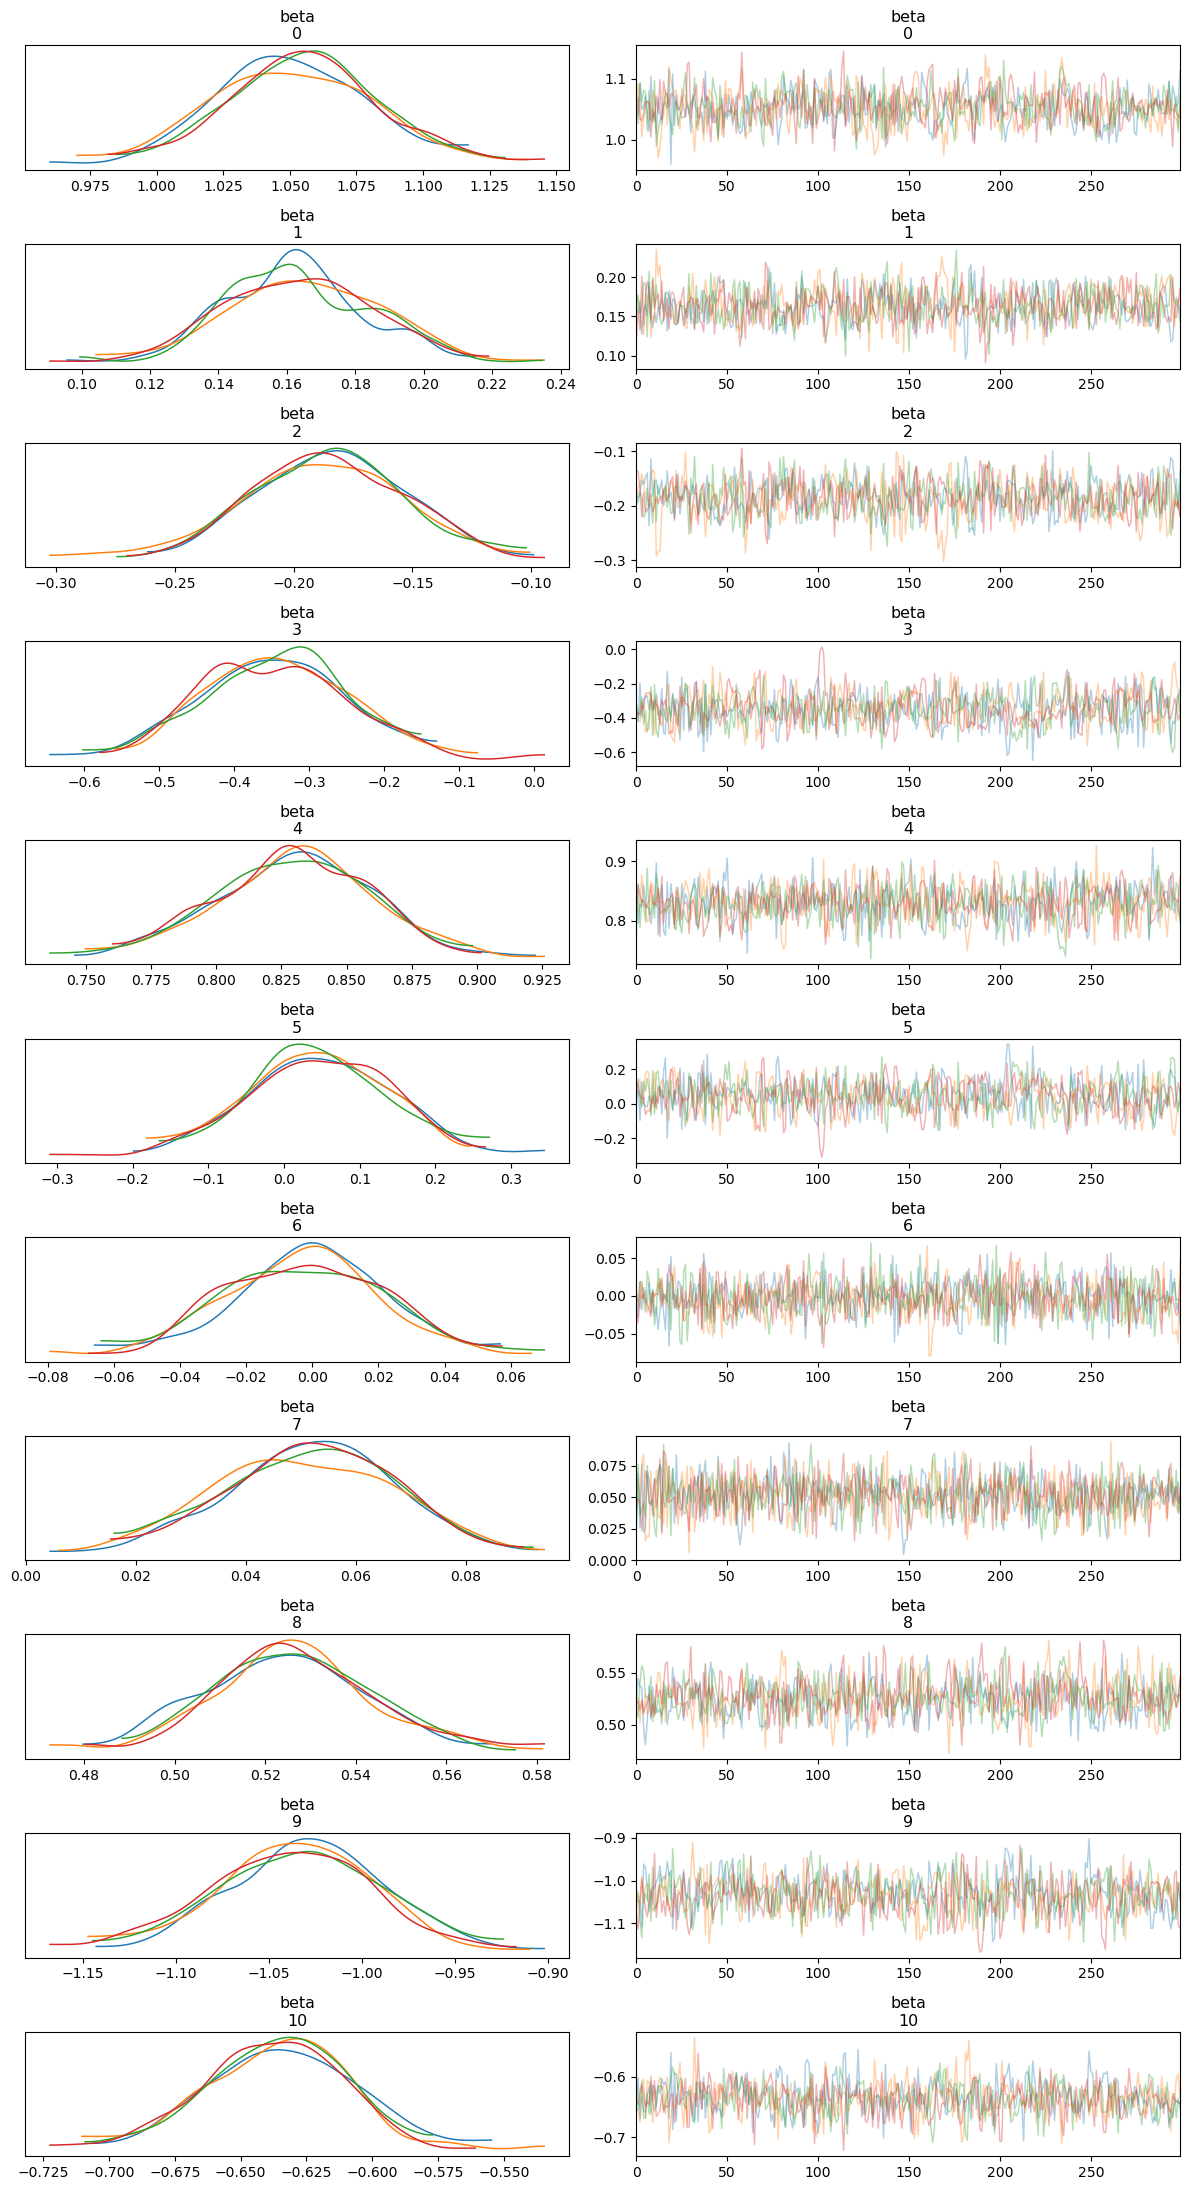

In [10]:
az.plot_trace(posterior_base_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [11]:
log_lik = fit_base.stan_variable("log_lik")
# print(type(log_lik))

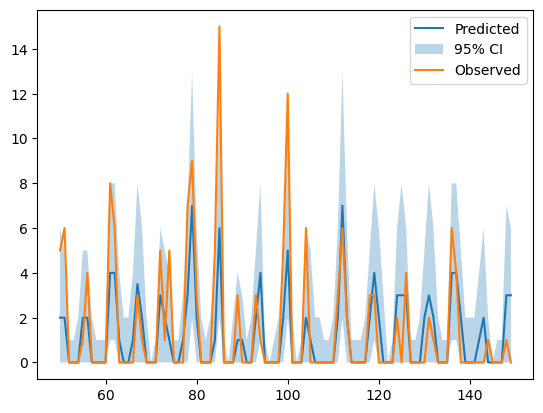

In [13]:
alpha=0.05
y_pred_obs = posterior_base_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(50, 150)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [15]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_base, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_base, var_name="log_lik")
print("LOO: ", loo_result)

WAIC:  Computed from 1200 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5432.50   117.43
p_waic       36.98        -

There has been a warning during the calculation. Please check the results.


C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


LOO:  Computed from 1200 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5432.65   117.43
p_loo       37.13        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [18]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_base_az.posterior.y_pred.median(dim=["chain", "draw"])


# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Inizializza un DataFrame vuoto
results_df = pd.DataFrame(columns=['Model', 'Percentage in CI', 'WAIC', 'LOO', 'MAD Median'])

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Base'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)


Percentage of Observed in 95% CI: 91.52%
Mean Absolute Deviation (MAD) sulla mediana: 1.1808035714285714
          Model  Percentage in CI         WAIC         LOO  MAD Median
0  Modello Base         91.517857 -5432.496784 -5432.64612    1.180804


C:\Users\leoma\AppData\Local\Temp\ipykernel_12284\2464644656.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_data], ignore_index=True)


Now we remove some variables, through two methods:\
    1. Variable selection through **SSVS**\
    2. Hard shrinkage in the posterior of the betas   
    
The code for the SSVS is on R in its folder, while the hard shrinkage will be in this file.

Given the SSVS paradigm, the covariates to remove are *max_consecutive_highwind_days*, *Densità*, *count_highwind*

In [19]:
##Code for hard shrinkage, hopefully same result
X.head

<bound method NDFrame.head of       mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0            -1.415564               -0.613095                 -0.033854   
1            -0.664023                2.562416                  2.016839   
2             0.441882               -0.190293                  0.325219   
3             1.467529               -1.011831                 -0.989703   
4             0.543283                1.328997                  0.370040   
...                ...                     ...                       ...   
3803          1.357083               -0.743306                 -1.189132   
3804          1.994391               -1.624094                 -1.865982   
3805          1.461331               -0.779083                 -1.125677   
3806          0.232652               -0.345014                 -0.642717   
3807         -0.349283               -1.091885                 -1.488275   

      mean_windspeed_10m_max  mean_radiation_sum  count_h

In [20]:
X = X.drop(columns=['max_consecutive_highwind_days', 'Densità', 'count_highwind'])

In [21]:
var_sel_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan180/var_sel_base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

var_sel_base = CmdStanModel(stan_file=stan_file)

14:55:19 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\var_sel_base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\var_sel_base.exe
14:55:43 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\var_sel_base.exe


In [22]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_var_sel = var_sel_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_val_sel_az = az.from_cmdstanpy(fit_var_sel)

14:55:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:55:52 - cmdstanpy - INFO - CmdStan done processing.


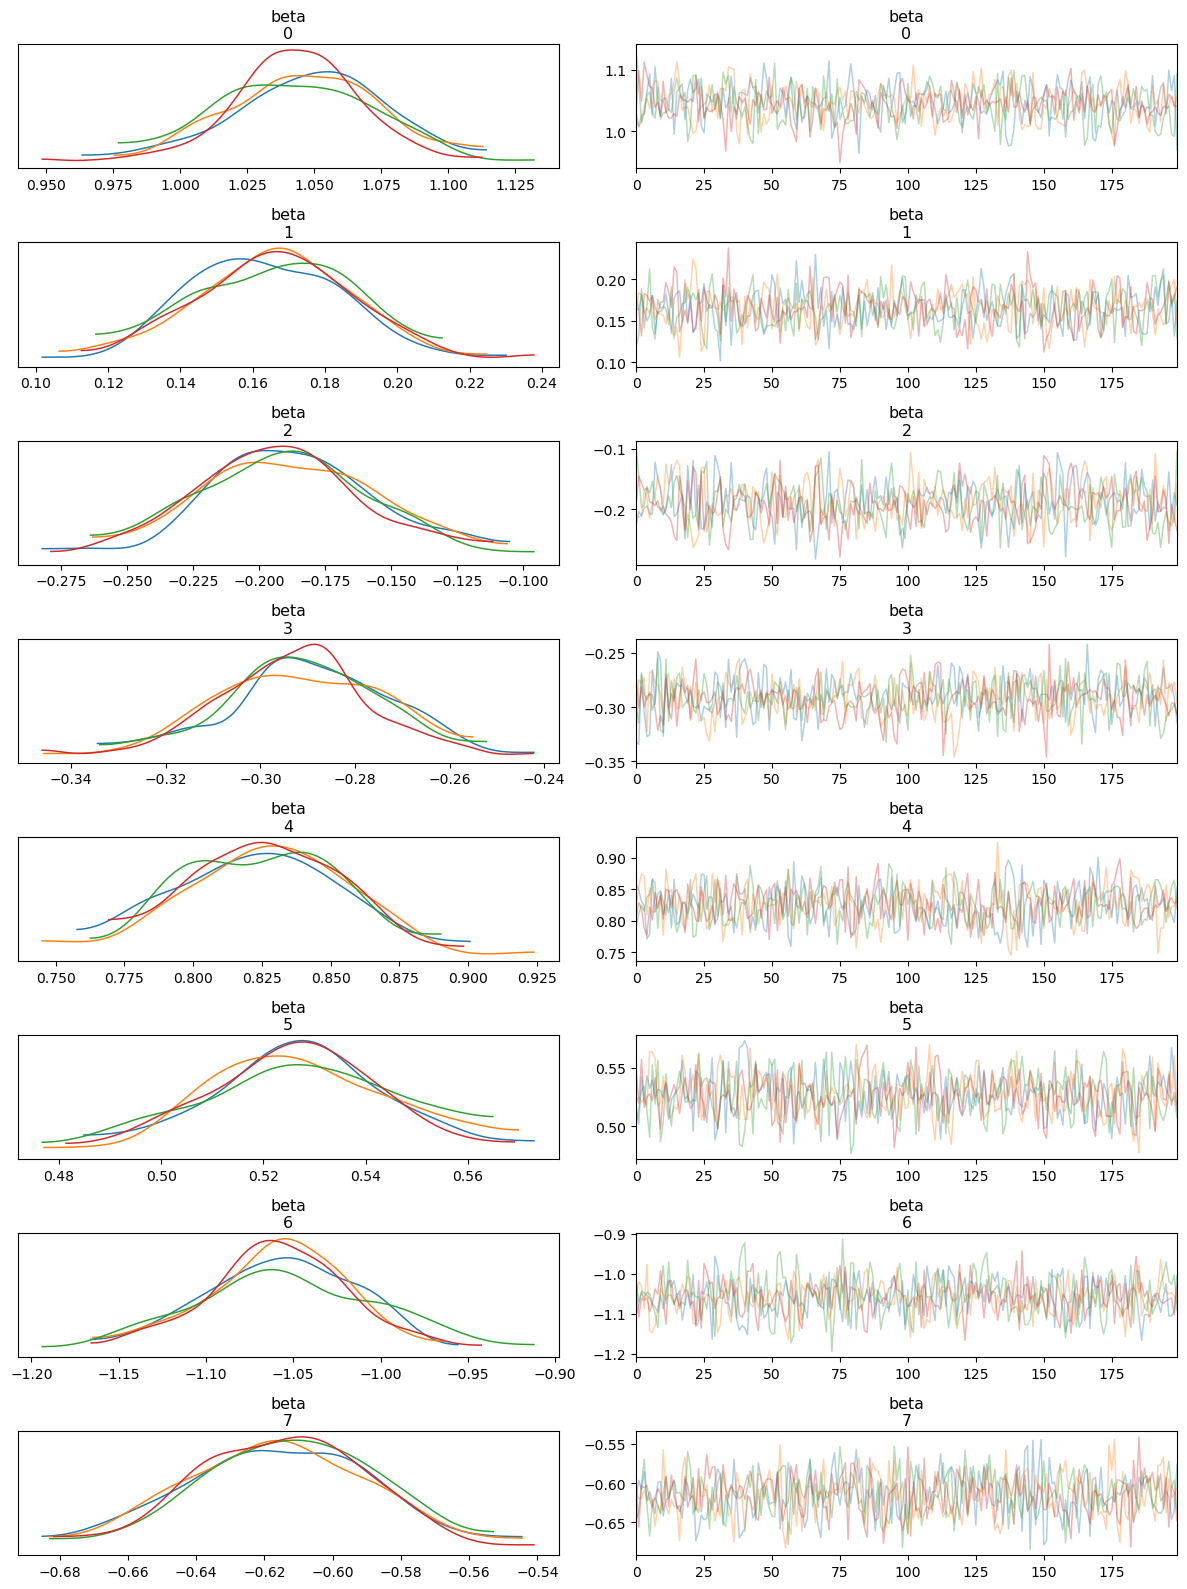

In [23]:
az.plot_trace(posterior_val_sel_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [24]:
log_lik = fit_var_sel.stan_variable("log_lik")
# print(type(log_lik))

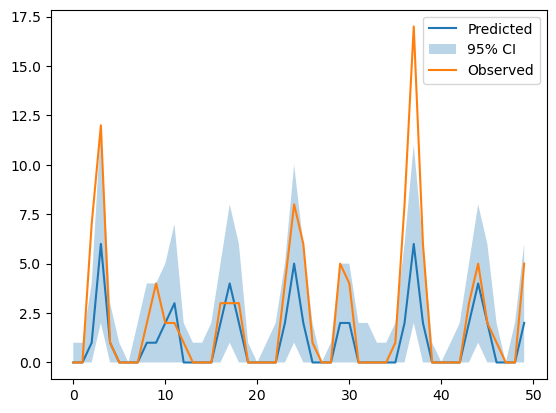

In [25]:
y_pred_obs = posterior_val_sel_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [26]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_var_sel, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_var_sel, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5432.32   117.28
p_waic       27.14        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5432.44   117.28
p_loo       27.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [27]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)

in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_val_sel_az.posterior.y_pred.median(dim=["chain", "draw"])


# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Variable Selection'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)


Percentage of Observed in 95% CI: 91.31%
Mean Absolute Deviation (MAD) sulla mediana: 1.178046218487395
                        Model  Percentage in CI         WAIC          LOO  \
0                Modello Base         91.517857 -5432.496784 -5432.646120   
1  Modello Variable Selection         91.307773 -5432.317495 -5432.437534   

   MAD Median  
0    1.180804  
1    1.178046  


# Fit improvement
The threshold of 180 is very unlikely to be overcomed, with respect to the 120-threshold.\
This result in the presence of more zeros, and indeed *too much zeros*.\
The method for overcoming this issue is the **zero inflated Poisson** and the following is the code to implement this metodologies.

In [28]:
#Code for improve the fit

## Year model:
We add the factor accounting for different years.

In [29]:
year_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;

  array[N] int<lower=1> year;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan180/years.stan"

with open(stan_file, "w") as f:
    print(year_model, file=f)

model_year = CmdStanModel(stan_file=stan_file)

14:56:03 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\years.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\years.exe
14:56:31 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\years.exe


In [30]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_years = model_year.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_years_az = az.from_cmdstanpy(fit_years)

14:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:56:46 - cmdstanpy - INFO - CmdStan done processing.


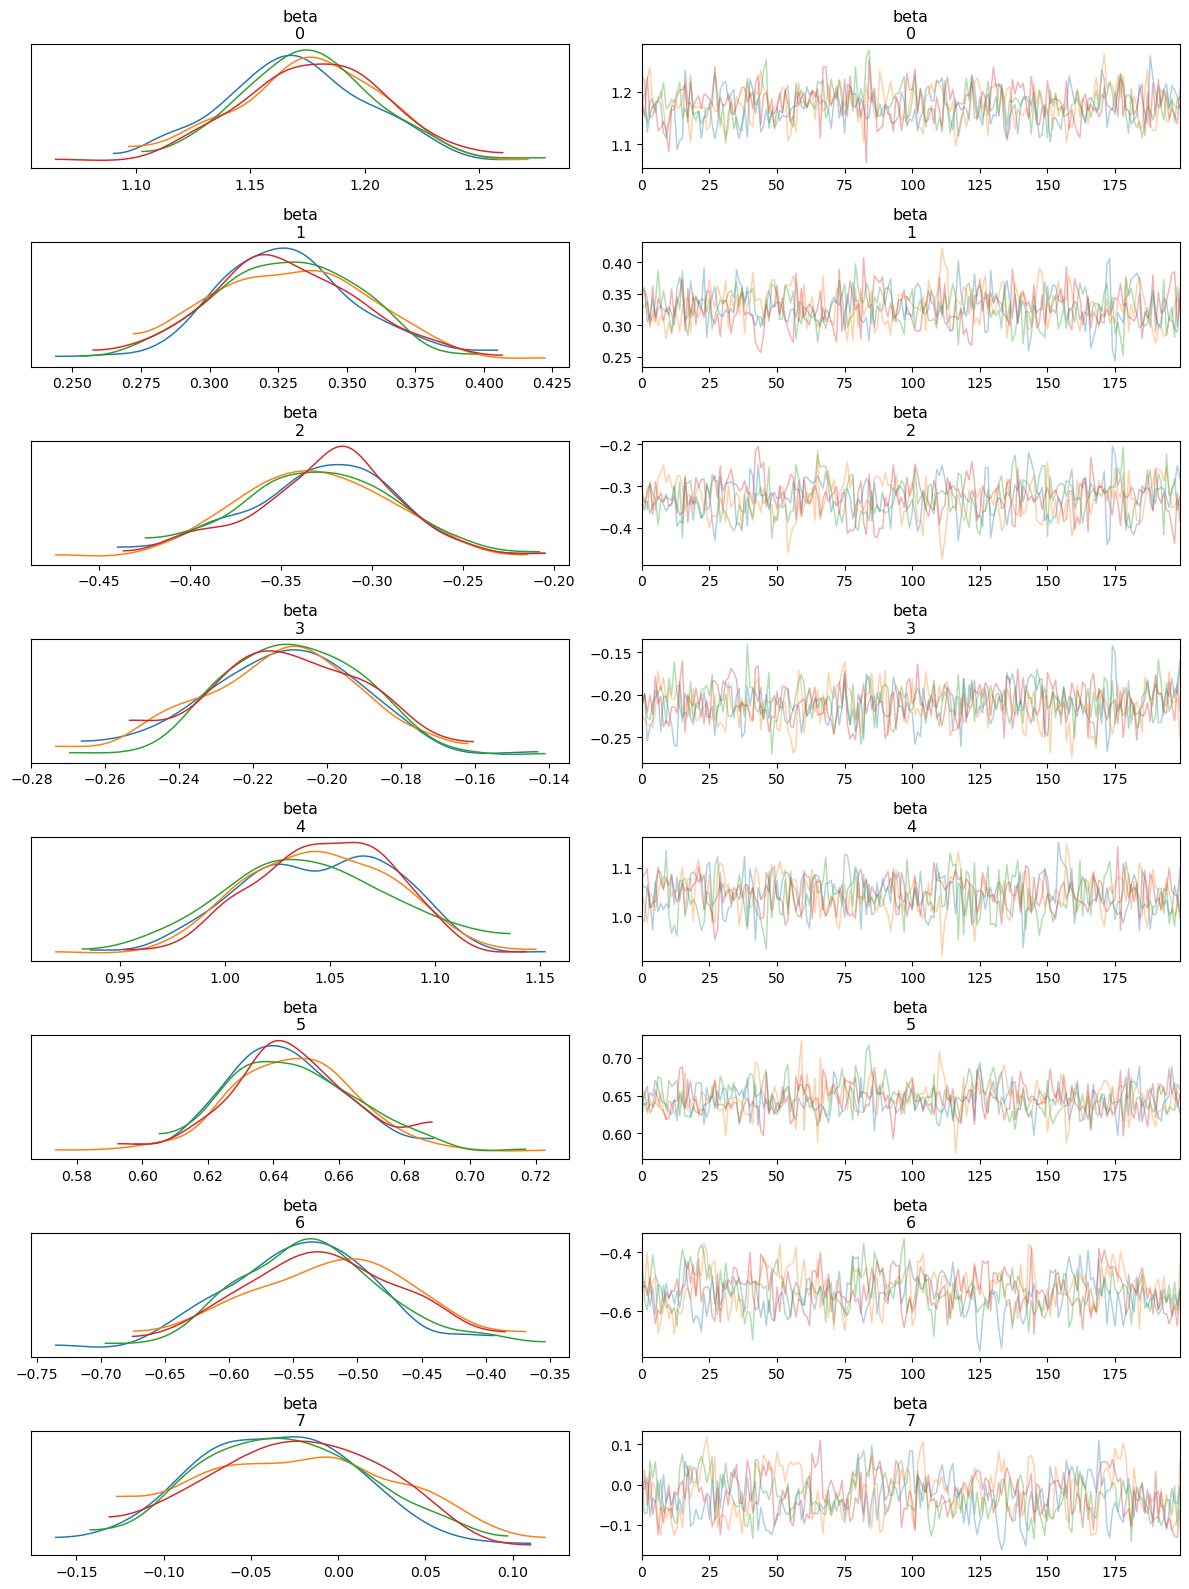

In [31]:
az.plot_trace(posterior_years_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [32]:
log_lik = fit_years.stan_variable("log_lik")
# print(type(log_lik))

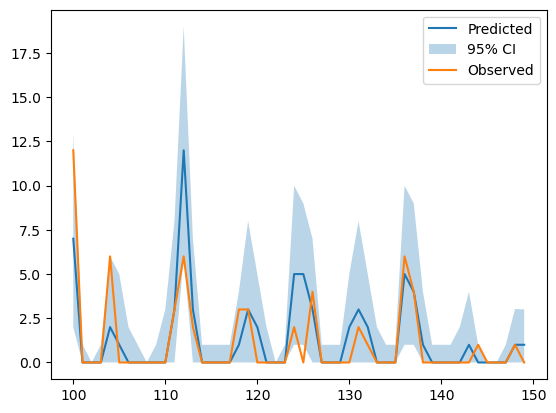

In [33]:
y_pred_obs = posterior_years_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(100, 150)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [34]:
# Crea un oggetto InferenceData contenente log_lik
#inference_years = az.from_cmdstanpy(fit_years, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_years, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_years, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4813.41   110.76
p_waic       56.82        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4813.65   110.76
p_loo       57.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [35]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_years_az.posterior.y_pred.median(dim=["chain", "draw"])


# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Years'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)


Percentage of Observed in 95% CI: 93.15%
Mean Absolute Deviation (MAD) sulla mediana: 1.0022321428571428
                        Model  Percentage in CI         WAIC          LOO  \
0                Modello Base         91.517857 -5432.496784 -5432.646120   
1  Modello Variable Selection         91.307773 -5432.317495 -5432.437534   
2               Modello Years         93.146008 -4813.412147 -4813.650103   

   MAD Median  
0    1.180804  
1    1.178046  
2    1.002232  


## Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [36]:
station_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);

}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}

}

"""

stan_file = "./stan180/station.stan"

with open(stan_file, "w") as f:
    print(station_model, file=f)

model_station = CmdStanModel(stan_file=stan_file)

14:56:58 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\station.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\station.exe
14:57:26 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\station.exe


In [37]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X
}


fit_stations = model_station.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_station_az = az.from_cmdstanpy(fit_stations)

14:57:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:58:50 - cmdstanpy - INFO - CmdStan done processing.


14:58:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 iterations at max treedepth (0.5%)
	Chain 4 had 1 iterations at max treedepth (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


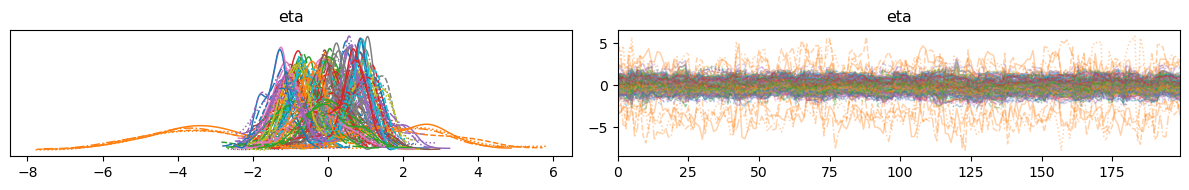

In [38]:
az.plot_trace(posterior_station_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

In [39]:
eta = posterior_station_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [40]:
lam = posterior_station_az['posterior']['lambda']
lam

<xarray.DataArray 'lambda' (chain: 4, draw: 200, lambda_dim_0: 3808)>
array([[[0.117969  , 0.403485  , 2.99359   , ..., 0.613672  ,
         0.0381947 , 0.00894854],
        [0.107079  , 0.309375  , 2.75213   , ..., 0.70838   ,
         0.0402276 , 0.0092437 ],
        [0.112777  , 0.311769  , 2.74077   , ..., 0.740743  ,
         0.0437905 , 0.0105981 ],
        ...,
        [0.111516  , 0.313911  , 2.82787   , ..., 0.949868  ,
         0.0571755 , 0.0137598 ],
        [0.106865  , 0.33765   , 2.88116   , ..., 0.482217  ,
         0.0281719 , 0.00641875],
        [0.124249  , 0.362983  , 3.14605   , ..., 0.643965  ,
         0.0382544 , 0.00927614]],

       [[0.0990207 , 0.324788  , 2.7861    , ..., 0.530018  ,
         0.0299286 , 0.0066946 ],
        [0.111191  , 0.284925  , 2.74777   , ..., 0.589358  ,
         0.0328551 , 0.00741533],
        [0.0980306 , 0.29522   , 2.47353   , ..., 0.665949  ,
         0.039893  , 0.00916245],
...
        [0.104434  , 0.320708  , 2.82272   , ..., 0.650613  ,
         0.0382109 , 0.00943495],
        [0.103344  , 0.281067  , 2.61571   , ..., 0.700145  ,
         0.0406257 , 0.0108934 ],
        [0.105862  , 0.288099  , 2.61862   , ..., 0.506675  ,
         0.0297015 , 0.00748443]],

       [[0.106107  , 0.295018  , 2.48266   , ..., 0.533622  ,
         0.0324912 , 0.0076304 ],
        [0.0997145 , 0.313881  , 2.74102   , ..., 0.723327  ,
         0.0395169 , 0.00859311],
        [0.113386  , 0.328431  , 2.96075   , ..., 0.611003  ,
         0.0349325 , 0.00816944],
        ...,
        [0.127619  , 0.315702  , 2.94318   , ..., 0.620511  ,
         0.0382119 , 0.00933818],
        [0.142756  , 0.381596  , 3.37621   , ..., 0.629124  ,
         0.0391569 , 0.00945528],
        [0.114946  , 0.333151  , 2.85856   , ..., 0.616292  ,
         0.0365989 , 0.0084775 ]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * lambda_dim_0  (lambda_dim_0) int32 0 1 2 3 4 5 ... 3803 3804 3805 3806 3807

In [41]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [42]:
inference_lam = []
for i in range(len(Y['Count_180'])):
    ar1 = lam[0, :, i]-Y['Count_180'][i]
    ar2 = lam[1, :, i]-Y['Count_180'][i]
    ar3 = lam[2, :, i]-Y['Count_180'][i]
    ar4 = lam[3, :, i]-Y['Count_180'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference_lam.append(current_iteration_df)

In [43]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [44]:
csv_path = '../Datasets/Space_estimate/eta_180.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [45]:
df = pd.DataFrame(inference_lam).transpose()
df.shape
df.columns.values

array([   0,    1,    2, ..., 3805, 3806, 3807], dtype=int64)

In [46]:
csv_path = '../Datasets/Space_estimate/res_180.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [47]:
log_lik = fit_stations.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


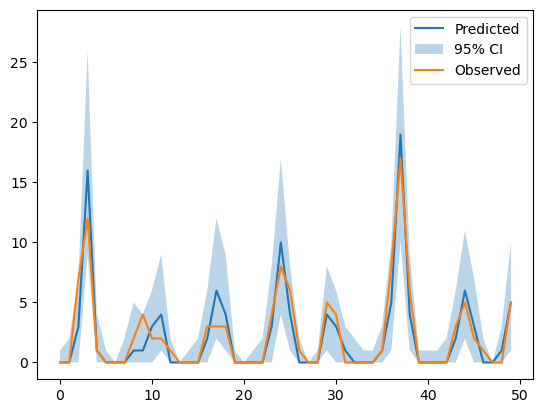

In [48]:
y_pred_obs = posterior_station_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [49]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y['Count_180']) | (y_star_up < Y['Count_180']))[0]
print(outliers.shape)

(124,)


In [50]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_stations, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_stations, var_name="log_lik")
print("LOO: ", loo_result)

WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.22    85.15
p_waic      104.91        -

There has been a warning during the calculation. Please check the results.


C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3837.97    85.17
p_loo      105.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3803   99.9%
 (0.5, 0.7]   (ok)          4    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [51]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)

in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_station_az.posterior.y_pred.median(dim=["chain", "draw"])


# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Stations'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)


Percentage of Observed in 95% CI: 96.74%
Mean Absolute Deviation (MAD) sulla mediana: 0.7186186974789915
                        Model  Percentage in CI         WAIC          LOO  \
0                Modello Base         91.517857 -5432.496784 -5432.646120   
1  Modello Variable Selection         91.307773 -5432.317495 -5432.437534   
2               Modello Years         93.146008 -4813.412147 -4813.650103   
3            Modello Stations         96.743697 -3837.219068 -3837.971908   

   MAD Median  
0    1.180804  
1    1.178046  
2    1.002232  
3    0.718619  


## Proper space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [74]:
space_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(1/phi) * distances);

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  real<lower = 0> sigma;
  real<lower = 0> sigma_beta;
  real<lower = 0> sigma_xi;

}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, sigma_beta);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, sigma_xi);
  eta ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma_beta ~ inv_gamma(4, 2);
  sigma_xi ~ inv_gamma(4, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan180/space.stan"

with open(stan_file, "w") as f:
    print(space_model, file=f)

model_space = CmdStanModel(stan_file=stan_file)

15:34:28 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\space.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\space.exe
15:35:11 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\space.exe


In [75]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [76]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_space_az = az.from_cmdstanpy(fit_space)

15:35:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:36:17 - cmdstanpy - INFO - CmdStan done processing.
15:36:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 38, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf 

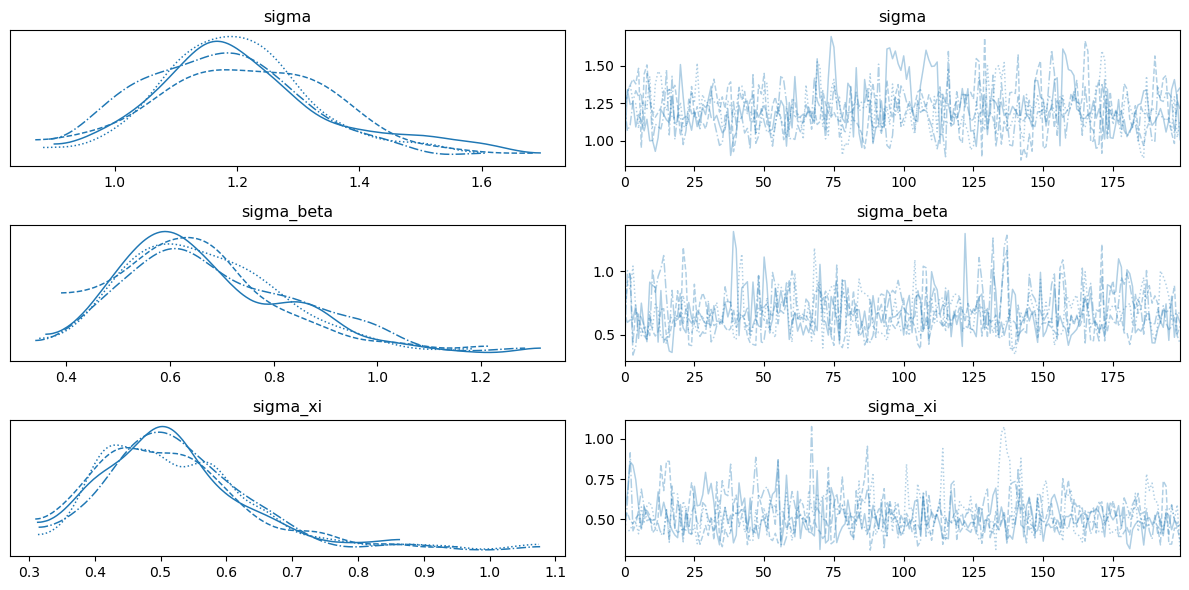

In [80]:
az.plot_trace(posterior_space_az, var_names = ['sigma', 'sigma_beta', 'sigma_xi'], compact=True)
plt.tight_layout()
plt.show()

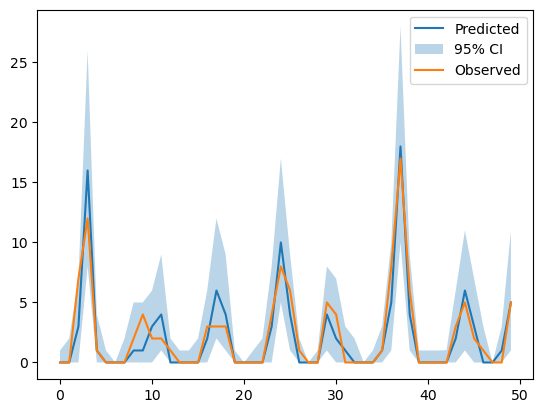

In [81]:
y_pred_obs = posterior_space_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [82]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y['Count_180']) | (y_star_up < Y['Count_180']))[0]
print(outliers.shape)

(121,)


In [83]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.25    84.65
p_waic      102.59        -

There has been a warning during the calculation. Please check the results.


C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO:  Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3838.11    84.69
p_loo      103.45        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3801   99.8%
 (0.5, 0.7]   (ok)          6    0.2%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [84]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)

in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_space_az.posterior.y_pred.median(dim=["chain", "draw"])

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space1'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)


Percentage of Observed in 95% CI: 96.82%
Mean Absolute Deviation (MAD) sulla mediana: 0.7219012605042017
                        Model  Percentage in CI         WAIC          LOO  \
0                Modello Base         91.517857 -5432.496784 -5432.646120   
1  Modello Variable Selection         91.307773 -5432.317495 -5432.437534   
2               Modello Years         93.146008 -4813.412147 -4813.650103   
3            Modello Stations         96.743697 -3837.219068 -3837.971908   
4              Modello Space1         96.953782 -3837.623064 -3838.438795   
5              Modello Space2         96.875000 -3837.634592 -3838.117459   
6              Modello Space2         96.875000 -3837.634592 -3838.117459   
7              Modello Space1         96.822479 -3837.253816 -3838.108845   

   MAD Median  
0    1.180804  
1    1.178046  
2    1.002232  
3    0.718619  
4    0.725315  
5    0.720982  
6    0.720982  
7    0.721901  


In [85]:
space_model_bis = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(1/(phi)) * (distances));

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma_eta;
  real<lower = 0> sigma_beta;
  real<lower = 0> sigma_xi;

}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; 
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations] + w[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, sigma_beta);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, sigma_xi);
  eta ~ normal(0, sigma_eta);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma_eta ~ inv_gamma(2, 2);
  sigma_beta ~ inv_gamma(4, 2);
  sigma_xi ~ inv_gamma(4, 2);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan180/space_bis.stan"

with open(stan_file, "w") as f:
    print(space_model_bis, file=f)

model_space_bis = CmdStanModel(stan_file=stan_file)

15:36:34 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\space_bis.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\space_bis.exe
15:37:15 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\space_bis.exe


In [92]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X,
    "phi": phi,
    "distances": distances
}


fit_space_bis = model_space_bis.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=3000)
posterior_space_bis_az = az.from_cmdstanpy(fit_space_bis)

15:40:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:50:07 - cmdstanpy - INFO - CmdStan done processing.
15:50:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 40, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 40, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 40, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 40, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 40, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 40, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] =

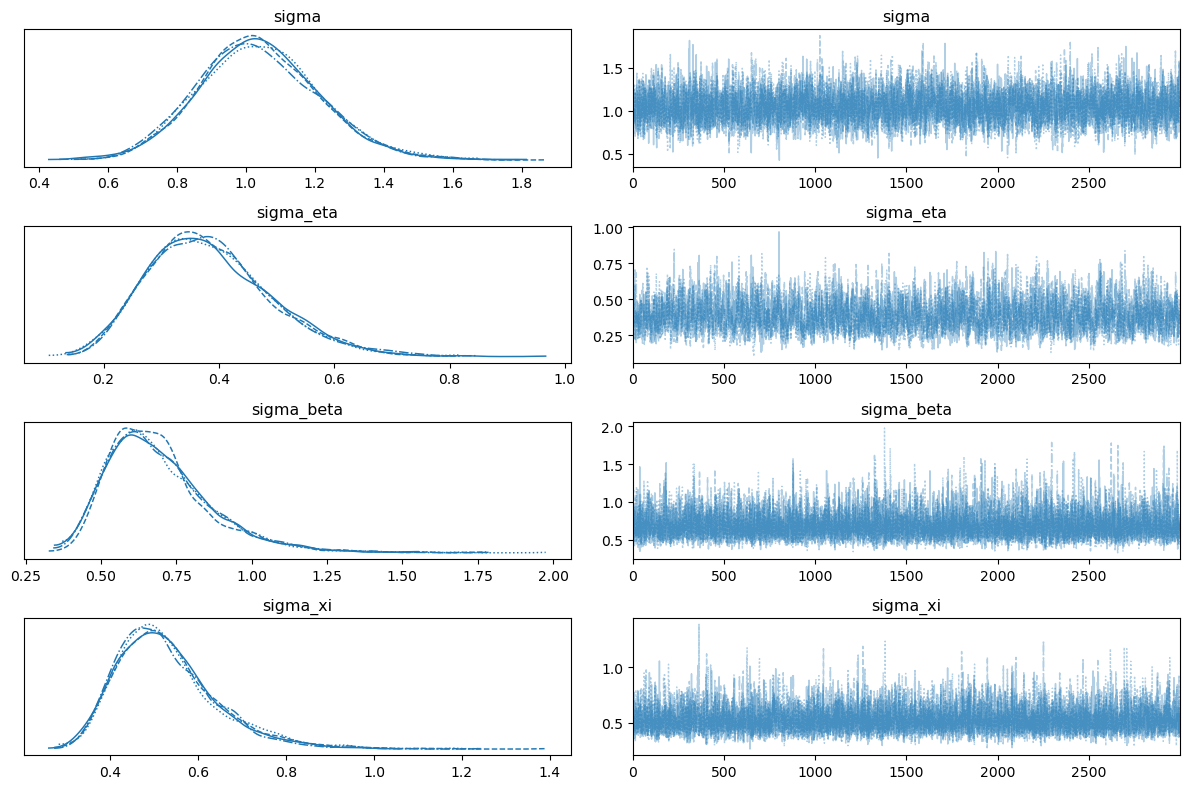

In [93]:
az.plot_trace(posterior_space_bis_az, var_names = ['sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'], compact=True)
plt.tight_layout()
plt.show()

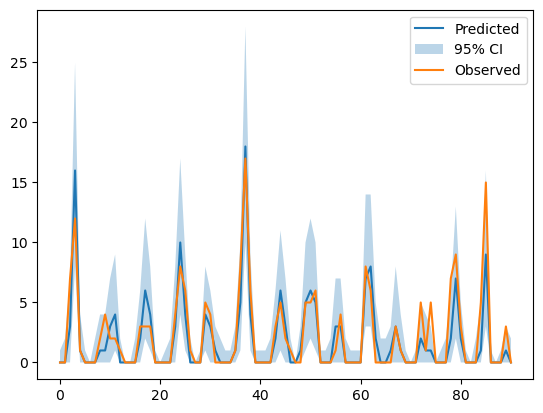

In [94]:
y_pred_obs = posterior_space_bis_az.posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']
xx = np.arange(0, 91)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [95]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y['Count_180']) | (y_star_up < Y['Count_180']))[0]
print(outliers.shape)

(117,)


In [96]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space_bis, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space_bis, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 12000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.26    84.72
p_waic      102.81        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 12000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3837.81    84.75
p_loo      103.36        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [97]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)

in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_space_bis_az.posterior.y_pred.median(dim=["chain", "draw"])


# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space2'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)


Percentage of Observed in 95% CI: 96.93%
Mean Absolute Deviation (MAD) sulla mediana: 0.7192752100840336
                        Model  Percentage in CI         WAIC          LOO  \
0                Modello Base         91.517857 -5432.496784 -5432.646120   
1  Modello Variable Selection         91.307773 -5432.317495 -5432.437534   
2               Modello Years         93.146008 -4813.412147 -4813.650103   
3            Modello Stations         96.743697 -3837.219068 -3837.971908   
4              Modello Space1         96.953782 -3837.623064 -3838.438795   
5              Modello Space2         96.875000 -3837.634592 -3838.117459   
6              Modello Space2         96.875000 -3837.634592 -3838.117459   
7              Modello Space1         96.822479 -3837.253816 -3838.108845   
8              Modello Space2         96.848739 -3836.019822 -3836.690424   
9              Modello Space2         96.927521 -3837.261985 -3837.814526   

   MAD Median  
0    1.180804  
1    1.178046  

## ZIP

Despite we talked about the zip in one of the first chunck of the code, it is a very computationally intensive algorithm and so we moved here for now.

In [99]:
        # Improving ZIP functions
spt_tools = \
"""
int num_zeros(array[] int y) {
    int sum = 0;
    for (n in 1:size(y))
      sum += (y[n] == 0);
    return sum;
  }
"""

# Write functions to file
stan_file = "stan180/spt_tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [102]:
zip_model = """
functions {
    #include "spt_tools.stan"
}

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  
  real phi;
  matrix[nstations, nstations] distances;
  
  int N1;
  matrix[N1, P] X1; // Non-zero Predictor matrix
  array[N1] int<lower=1> year1;
  array[N1] int<lower=1> stations1;
  
}

transformed data {
  matrix[nstations,nstations] H = exp(-phi * distances);


  int<lower = 0> N_zero = num_zeros(y);
  array[N1] int<lower = 1> y_nonzero;
  int N_nonzero = 0;
  for (n in 1:N) {
    if (y[n] == 0) continue;
    N_nonzero += 1;
    y_nonzero[N_nonzero] = y[n];
  }
}

parameters {
  vector[P] beta; // Coefficients for predictors
  real<lower=0, upper=1> theta; // Probability of excess zeros
  
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  vector[nstations] w; //Random zero-mean effect for the space model
  
  real<lower = 0> sigma;
  real<lower = 0> sigma_beta;
  real<lower = 0> sigma_xi;
  real<lower = 0> sigma_eta;
  
}

transformed parameters {
  
    vector[N1] lambda;
    vector[N1] fix_eff;
    vector[N1] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; 
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);

    fix_eff = X1 * beta;
    intercept = eta[stations1] + xi[year1] + w[stations1];

    lambda = exp(fix_eff + intercept);
    
}

model {
  beta ~ normal(0, sigma_beta);

  xi ~ normal(0, sigma_xi);
  eta ~ normal(0, sigma_eta);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma_eta ~ inv_gamma(2, 2);
  sigma_beta ~ inv_gamma(4, 2);
  sigma_xi ~ inv_gamma(4, 2);

  theta ~ beta(0.5, 0.5); // Prior for excess zeros probability
  
target
     += N_zero
          * log_sum_exp(bernoulli_lpmf(1 | theta),
                        bernoulli_lpmf(0 | theta)
                          + poisson_lpmf(0 | lambda));
   target += N_nonzero * bernoulli_lpmf(0 | theta);
   target += poisson_lpmf(y_nonzero | lambda);
}

generated quantities{
 vector[N] log_lik;
 vector[N1] y_pred;
 
 for(i in 1:N){
   log_lik[i] = N_zero
          * log_sum_exp(bernoulli_lpmf(1|theta),
                        bernoulli_lpmf(0|theta)
                          + poisson_lpmf(0|lambda));
   log_lik[i] = N_nonzero * bernoulli_lpmf(0|theta);
   log_lik[i] = poisson_lpmf(y_nonzero|lambda);
   
   y_pred[i] = poisson_rng(lambda[i]); // da capire come inserirlo

}

}


"""

stan_file = "stan180/zip.stan"

with open(stan_file, "w") as f:
    print(zip_model, file=f)

model_zip = CmdStanModel(stan_file=stan_file)

16:03:25 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan180\zip.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\zip.exe
16:04:07 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan180\zip.exe


In [74]:
#N1 n-nzero
Nzero = sum((Y['Count_180'])==0)

N1 = len(Y) - Nzero

# Identify rows in Y where 'Count_180' column equals zero
rows_to_drop = Y[Y['Count_180'] == 0].index

# Create a new DataFrame X1 by copying X and dropping rows identified in Y
X1 = X.drop(rows_to_drop)

stations1 = pd.read_csv("../Datasets/stazzip.csv")
stations1 = stations1['x']
len(stations1)
unique_values = sorted(set(stations1))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
stations1 = [mapping_dict[value] for value in stations1]
year1 = pd.read_csv("../Datasets/yearzip.csv")
year1 = year1['x']-2009
year1

0        1
1        1
2        1
3        2
4        2
        ..
1262     9
1263    10
1264    10
1265    12
1266    13
Name: x, Length: 1267, dtype: int64

In [75]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": transformed_stations,
    "year": years,
    "y": Y['Count_180'],
    "X": X,
    "phi" : phi,
    "distances" : distances,
    "N1" : N1,
    "X1" : X1,
    "stations1" : stations1,
    "year1" : year1
}

# require 40 min for iter_warmup=1000 and iter_sampling=2000
fit_zip = model_zip.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=2000)
posterior_zip_az = az.from_cmdstanpy(fit_zip)

14:03:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▋         | 00:06 Iteration:    1 / 3000 [  0%]  (Warmup)





chain 1 |▉         | 00:15 Iteration:  100 / 3000 [  3%]  (Warmup)
chain 1 |█▎        | 00:24 Iteration:  200 / 3000 [  6%]  (Warmup)




chain 1 |█▌        | 00:33 Iteration:  300 / 3000 [ 10%]  (Warmup)


chain 1 |█▉        | 00:42 Iteration:  400 / 3000 [ 13%]  (Warmup)


chain 1 |██▏       | 00:50 Iteration:  500 / 3000 [ 16%]  (Warmup)


chain 1 |██▌       | 00:57 Iteration:  600 / 3000 [ 20%]  (Warmup)




chain 1 |██▊       | 01:03 Iteration:  700 / 3000 [ 23%]  (Warmup)




chain 1 |███▏      | 01:10 Iteration:  800 / 3000 [ 26%]  (Warmup)
chain 1 |███▍      | 01:18 Iteration:  900 / 3000 [ 30%]  (Warmup)


chain 1 |████      | 01:56 Iteration: 1001 / 3000 [ 33%]  (Sampling)

chain 1 |████▍     | 02:32 Iteration: 1100 / 3000 [ 36%]  (Sampling)


chain 1 |████▋     | 03:10 Iteration: 1200 / 3000 [ 40%]  (Sampling)


ch


14:17:09 - cmdstanpy - INFO - CmdStan done processing.
14:17:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, column 3 to column 38)
	Exception: vector[uni] indexing: accessing element out of range. index 1268 out of range; expecting index to be between 1 and 1267 (in 'zip.stan', line 93, co

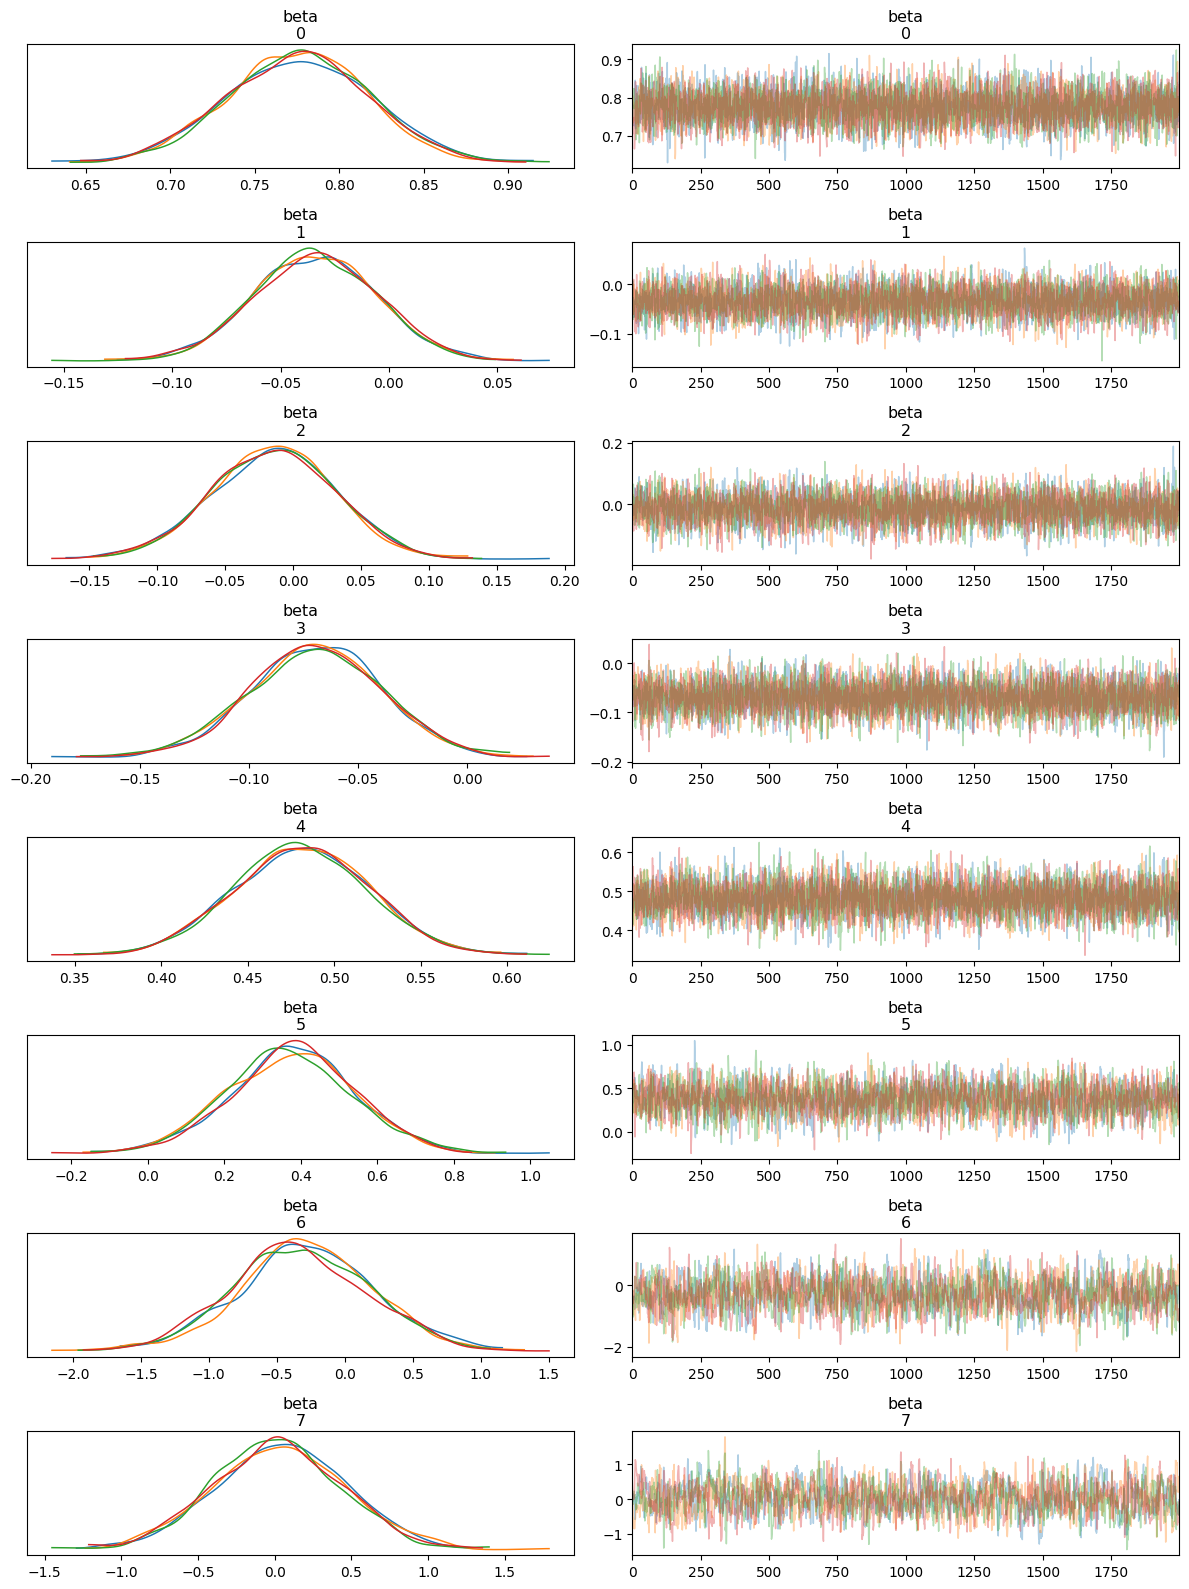

In [76]:
az.plot_trace(posterior_zip_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

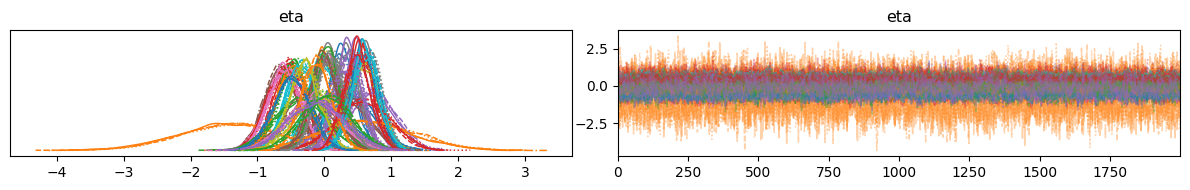

In [77]:
az.plot_trace(posterior_zip_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

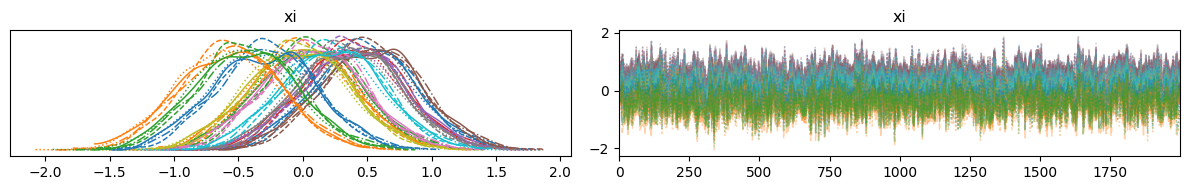

In [78]:
az.plot_trace(posterior_zip_az, var_names = ['xi'], compact=True)
plt.tight_layout()
plt.show()

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


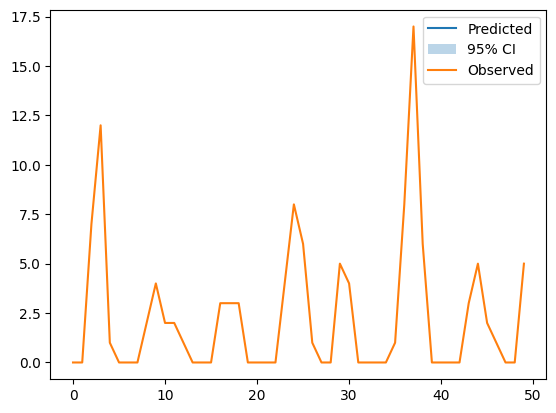

In [79]:
y_star = posterior_zip_az.posterior.y_pred.median(dim=["chain", "draw"])
y_star_up = posterior_zip_az.posterior.y_pred.quantile(q=0.975, dim=["chain", "draw"])
y_star_low = posterior_zip_az.posterior.y_pred.quantile(q=0.025, dim=["chain", "draw"])
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted")
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI")
plt.plot(xx, Y.loc[xx, 'Count_180'], label="Observed")
plt.legend()
plt.show()

In [80]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_zip, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_zip, var_name="log_lik")
print("LOO: ", loo_result)

WAIC:  Computed from 8000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -


arviz - WARNING - Array contains NaN-value.
c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO:  Computed from 8000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo      nan      nan
p_loo         nan        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 3808  100.0%



In [81]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
y_star_up = posterior_zip_az.posterior.y_pred.quantile(q=0.975, dim=["chain", "draw"])
y_star_low = posterior_zip_az.posterior.y_pred.quantile(q=0.025, dim=["chain", "draw"])

in_ci = np.logical_and(Y['Count_180'] >= y_star_low, Y['Count_180'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = posterior_zip_az.posterior.y_pred.median(dim=["chain", "draw"])


# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_180'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space2'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


ValueError: Lengths must match to compare